Goal is to create read / write functions for FeatureCollections to AWS RDS PostGreSQL 


This script contains the following options:

fc -> Geopandas -> postGIS  
PostGIS -> GeoPandas -> fc


In [1]:
%matplotlib inline

In [89]:
import ee
import geopandas as gpd
import folium

import shapely

import boto3
import botocore
import sqlalchemy
import geoalchemy2

#from shapely.geometry.multipolygon import MultiPolygon
#from shapely.geometry import shape

In [3]:
ee.Initialize()

In [4]:
fc = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017");       

In [5]:
fcEu = fc.filter(ee.Filter.eq("wld_rgn","Europe"))

In [76]:
# Database settings
OUTPUT_VERSION= 1

DATABASE_IDENTIFIER = "aqueduct30v03"
DATABASE_NAME = "database01"
TABLE_NAME = "hydrobasin6_v%0.2d" %(OUTPUT_VERSION)

In [139]:
def rdsConnect(database_identifier,database_name):
    """open a connection to AWS RDS
    
    in addition to specifying the arguments you need to store your password in a file called .password in the current working directory. 
    You can do this using the command line or Jupyter. Make sure to have your .gitignore file up to date.
    
    Args:
        database_identifier (string) : database identifier used when you set up the AWS RDS instance
        database_name (string) : the database name to connect to
        
    Returns:
        engine (sqlalchemy.engine.base.Engine) : database engine
        connection (sqlalchemy.engine.base.Connection) : database connection
    """
    
    
    rds = boto3.client('rds')
    F = open(".password","r")
    password = F.read().splitlines()[0]
    F.close()
    response = rds.describe_db_instances(DBInstanceIdentifier="%s"%(database_identifier))
    status = response["DBInstances"][0]["DBInstanceStatus"]
    print("Status:",status)
    endpoint = response["DBInstances"][0]["Endpoint"]["Address"]
    print("Endpoint:",endpoint)
    engine = sqlalchemy.create_engine('postgresql://rutgerhofste:%s@%s:5432/%s' %(password,endpoint,database_name))
    connection = engine.connect()
    return engine, connection


def fcToGdf(fc, crs = {'init' :'epsg:4326'}):
    """converts a featurecollection to a geoPandas GeoDataFrame
    
    Args:
        fc (ee.FeatureCollection) : the earth engine feature collection to convert. Size is limited to memory (geopandas limitation)
        crs (dictionary, optional) : the coordinate reference system in geopandas format. Defaults to {'init' :'epsg:4326'}
        
    Returns:
        gdf (geoPandas.GeoDataFrame) : the corresponding geodataframe
    
    """
    
    features = fc.getInfo()['features']

    dictarr = []

    for f in features:
        attr = f['properties']
        attr['geometry'] = f['geometry']  
        dictarr.append(attr)

    gdf = gpd.GeoDataFrame(dictarr)
    gdf['geometry'] = map(lambda s: shapely.geometry.shape(s), gdf.geometry)
    gdf.crs = crs
    return gdf


def GdfToPostGIS(connection, gdf,tableName,saveIndex = True):
    """this function uploads a geodataframe to table in AWS RDS.
    
    It handles combined polygon/multipolygon geometry and stores it in valid multipolygon in epsg 4326.
    
    Args:
        connection (sqlalchemy.engine.base.Connection) : postGIS enabled database connection 
        gdf (geoPandas.GeoDataFrame) : input geoDataFrame
        tableName (string) : postGIS table name (string)
        saveIndex (boolean, optional) : save geoDataFrame index column in separate column in postgresql, otherwise discarded. Default is True
        
    Returns:
        gdf (geoPandas.GeoDataFrame) : the geodataframe loaded from the database. Should match the input dataframe
    
    todo:
        currently removes table if exists. Include option to break or append
    
    """   
    
    gdf["type"] = gdf.geometry.geom_type    
    geomTypes = ["Polygon","MultiPolygon"]
    
    for geomType in geomTypes:
        gdfType = gdf.loc[gdf["type"]== geomType]
        geomTypeLower = str.lower(geomType)
        gdfType['geom'] = gdfType['geometry'].apply(lambda x: geoalchemy2.WKTElement(x.wkt, srid=4326))
        gdfType.drop(["geometry","type"],1, inplace=True)      
        print("Create table temp%s" %(geomTypeLower)) 
        gdfType.to_sql(
            name = "temp%s" %(geomTypeLower),
            con = engine,
            if_exists='replace',
            index= saveIndex, 
            dtype={'geom': geoalchemy2.Geometry(str.upper(geomType), srid= 4326)}
        )
        
    # Merge both tables and make valid
    sql = []
    sql.append("DROP TABLE IF EXISTS %s"  %(tableName))
    sql.append("ALTER TABLE temppolygon ALTER COLUMN geom type geometry(MultiPolygon, 4326) using ST_Multi(geom);")
    sql.append("CREATE TABLE %s AS (SELECT * FROM temppolygon UNION SELECT * FROM tempmultipolygon);" %(tableName))
    sql.append("UPDATE %s SET geom = st_makevalid(geom);" %(tableName))
    sql.append("DROP TABLE temppolygon,tempmultipolygon")

    for statement in sql:
        print(statement)
        result = connection.execute(statement)    
    gdfFromSQL =gpd.GeoDataFrame.from_postgis("select * from %s" %(tableName),connection,geom_col='geom' )
    return gdfFromSQL


def PostGisToGdf(connection,tableName):
    """this function gets a geoDataFrame from a postGIS database instance
    
    
    Args:
        connection (sqlalchemy.engine.base.Connection) : postGIS enabled database connection 
        tableName (string) : table name
 
    Returns:
        gdf (geoPandas.GeoDataFrame) : the geodataframe from PostGIS
        
    todo:
        allow for SQL filtering
    
    
    """   
    gdf =gpd.GeoDataFrame.from_postgis("select * from %s" %(tableName),connection,geom_col='geom' )
    gdf.crs =  {'init' :'epsg:4326'}
    return gdf

def RowAddFeature(row):
    """Adds a column with ee features to a geodataframe row
    
    Args:
        gdf row (geoDataFrame row) : the input row
        
    Returns:
        gdf row (geoDataFrame row) : the input row with an added feature
    
    """
    geom = row["geom"]
    geomType = row["geom"].geom_type
    
    if geomType == "MultiPolygon":
        geometry = ee.Geometry.MultiPolygon(geom)
    row["feature"] = geomType
    row["geometry"]  = geometry
    return row
    
    

def gdfToFc(gdf):
    """converts a geodataframe  to a featurecollection
    
    Args:
        gdf (geoPandas.GeoDataFrame) : the input geodataframe
        
    Returns:
        fc (ee.FeatureCollection) : feature collection (server  side)  
    
    
    """
    gdfCopy = gdf.copy()
    gdfCopy["geomJSON"] = gdf["geom"].to_json
    
    featureList = []
    
    gdf.apply()
    
    
    geometry = ee.Geometry.Multipolygon([[-121.68, 39.91], [-97.38, 40.34]]);
    properties = {"rutger":42,"freek":26}
    feature = ee.Feature(geometry,properties)
    
    featureList.append(feature)
    
    fc = ee.FeatureCollection(featureList)
    
    return fc


In [123]:
geom = gdfToFc(gdf)

TypeError: apply() takes at least 2 arguments (1 given)

In [148]:
gdfCopy = gdf.copy()
gdfCopy["geomJSON"] = gdf["geom"].to_json()

In [149]:
gdfCopy.head()

,index,abbreviati,country_co,country_na,wld_rgn,geom,geomJSON
0,15,Ser.,RI,Serbia,Europe,"(POLYGON ((19.03237730423286 45.4880337885867,...","{""type"": ""FeatureCollection"", ""features"": [{""g..."
1,16,Gr.,GR,Greece,Europe,(POLYGON ((24.64744381515608 40.56872174657097...,"{""type"": ""FeatureCollection"", ""features"": [{""g..."
2,17,Mace.,MK,Macedonia,Europe,(POLYGON ((22.92717359492812 41.33848962117496...,"{""type"": ""FeatureCollection"", ""features"": [{""g..."
3,18,Kos.,KV,Kosovo,Europe,(POLYGON ((20.59429846332493 41.87732324224904...,"{""type"": ""FeatureCollection"", ""features"": [{""g..."
4,19,Bulg.,BU,Bulgaria,Europe,(POLYGON ((26.35814999524675 41.71118351553066...,"{""type"": ""FeatureCollection"", ""features"": [{""g..."


In [150]:
row  = gdfCopy.loc[1]

In [151]:
geom = row["geomJSON"]

In [158]:
len(geom)

23291263

In [157]:
ee.Feature(geom,{"rutger":42})

EEException: Invalid GeoJSON geometry.

RuntimeError: maximum recursion depth exceeded in cmp

In [140]:
gdf2 = gdf.apply(RowAddFeature, axis=1)

EEException: ('Invalid geometry.', u'occurred at index 0')

In [138]:
gdf2.head()

,index,abbreviati,country_co,country_na,wld_rgn,geom,feature
0,15,Ser.,RI,Serbia,Europe,"(POLYGON ((19.03237730423286 45.4880337885867,...",MultiPolygon
1,16,Gr.,GR,Greece,Europe,(POLYGON ((24.64744381515608 40.56872174657097...,MultiPolygon
2,17,Mace.,MK,Macedonia,Europe,(POLYGON ((22.92717359492812 41.33848962117496...,MultiPolygon
3,18,Kos.,KV,Kosovo,Europe,(POLYGON ((20.59429846332493 41.87732324224904...,MultiPolygon
4,19,Bulg.,BU,Bulgaria,Europe,(POLYGON ((26.35814999524675 41.71118351553066...,MultiPolygon


In [109]:
task = ee.batch.Export.table.toDrive(    
    collection =  fcEu ,
    description = "description" ,
    fileNamePrefix = "test01",
    fileFormat = "KML"
)
task.start()


In [53]:
test = fcEu.getInfo()

In [65]:
test.keys()

[u'features', u'properties', u'version', u'type', u'id', u'columns']

In [67]:
gdf = fcToGdf(fcEu)

In [90]:
gdfFromSQL = GdftoPostGIS(connection, gdf,"test01",True)

/opt/anaconda3/envs/python27/lib/python2.7/site-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda3/envs/python27/lib/python2.7/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Create table temppolygon
Create table tempmultipolygon
DROP TABLE IF EXISTS test01
ALTER TABLE temppolygon ALTER COLUMN geom type geometry(MultiPolygon, 4326) using ST_Multi(geom);
CREATE TABLE test01 AS (SELECT * FROM temppolygon UNION SELECT * FROM tempmultipolygon);
UPDATE test01 SET geom = st_makevalid(geom);
DROP TABLE temppolygon,tempmultipolygon


In [91]:
gdfFromSQL

,index,abbreviati,country_co,country_na,wld_rgn,geom
0,15,Ser.,RI,Serbia,Europe,"(POLYGON ((19.03237730423286 45.4880337885867,..."
1,16,Gr.,GR,Greece,Europe,(POLYGON ((24.64744381515608 40.56872174657097...
2,17,Mace.,MK,Macedonia,Europe,(POLYGON ((22.92717359492812 41.33848962117496...
3,18,Kos.,KV,Kosovo,Europe,(POLYGON ((20.59429846332493 41.87732324224904...
4,19,Bulg.,BU,Bulgaria,Europe,(POLYGON ((26.35814999524675 41.71118351553066...
5,20,Rus.,RS,Russia,Europe,(POLYGON ((29.78448000768552 59.97023996428151...
6,21,Ukr.,UP,Ukraine,Europe,(POLYGON ((32.01916500410072 46.17288970654994...
7,22,Rom.,RO,Romania,Europe,(POLYGON ((22.67613525961454 44.21545792547196...
8,23,Mol.,MD,Moldova,Europe,(POLYGON ((28.21133573386631 45.46690602171712...
9,24,Rus.,RS,Russia,Europe,"(POLYGON ((58.17502578130372 81.6911926273429,..."


In [54]:
from sys import getsizeof

In [62]:
features = test["features"]

In [82]:
engine, connection = rdsConnect(DATABASE_IDENTIFIER,DATABASE_NAME)

('Status:', 'available')
('Endpoint:', 'aqueduct30v03.cgpnumwmfcqc.eu-central-1.rds.amazonaws.com')


In [83]:
type(engine)

sqlalchemy.engine.base.Engine

In [84]:
type(connection)

sqlalchemy.engine.base.Connection

In [94]:
gdf = PostGisToGdf(connection,"test01")

In [11]:
geoSeries = gpd.GeoSeries(geom2)
geoSeries.crs = {'init' :'epsg:4326'}

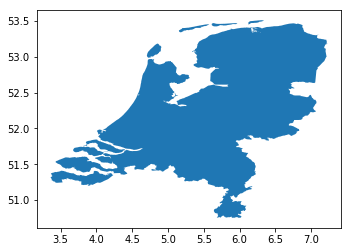

In [12]:
geoSeries.plot()

In [27]:
gdf = gpd.GeoDataFrame(geometry=geoSeries)

In [19]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [21]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,28400000.0,Asia,Afghanistan,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,..."
1,12799293.0,Africa,Angola,AGO,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...
2,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,..."
3,4798491.0,Asia,United Arab Emirates,ARE,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,..."
4,40913584.0,South America,Argentina,ARG,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...


In [13]:
geoSeriesJSON = geoSeries.to_json

In [29]:
multiPolygon = folium.features.GeoJson(gdf)

In [30]:
m = folium.Map([0, 0], zoom_start=3)


In [31]:
m.add_child(multiPolygon)

In [ ]:
m